# Rabi frequency under noisy electric field in growth direction 

Here, I directly generate Hamiltonian with quantum well confining potential and find ground state to calculate Rabi frequency.    

$H = \frac{\hbar^2}{2m_l}k_z^2 + V_0 \cos(\frac{2\pi z}{\lambda}) + V_l (z) + \acute V_{0000}(z) + eF_z  $

- Quantum well : sigmoid well with wiggles, $V_0 \cos(\frac{2\pi z}{\lambda}) + V_l (z)$      
- Out of plane electric field $F_z$ : $ F_z \sim N(F_z^0, \sigma (F_z))$    
- Alloy disorder term : averaged over quantum dot in plane, $\acute V_{0000} (z) $

First, solve this Hamiltonian with numpy library to find ground state $\phi(z)$ with electric field noise. 

Next, calculate expectation values such as $\Delta_{0000}$, $\Delta_{1000}$ and $\beta_{00}$ that appear in Rabi frequency. 

Finally, calculate Rabi frequency $\Omega$ and find distribution of it. 


In [1]:
from values import *
from utils import *
import matplotlib.pyplot as plt 
from datetime import datetime

%load_ext autoreload
%autoreload 2


## 1. Check functions 

### 1-1 Visualize Ge profile or Confining potential 
Used sigmoid function to make the well, and also included wiggles.  

$n(z)= n_{bar} (2-\frac{1}{1 +  \exp(\frac{4(-z - d/2)} { w})}-\frac{1}{1 + \exp(\frac{4(z - d/2)} { w})}) + (2 n_{GE} \sin(\frac{\pi z }{\lambda})^2)$


Interface width ($w$), size of well ($d$), and band offsets ($E_{GE}$) are defined in 'values.py' file 

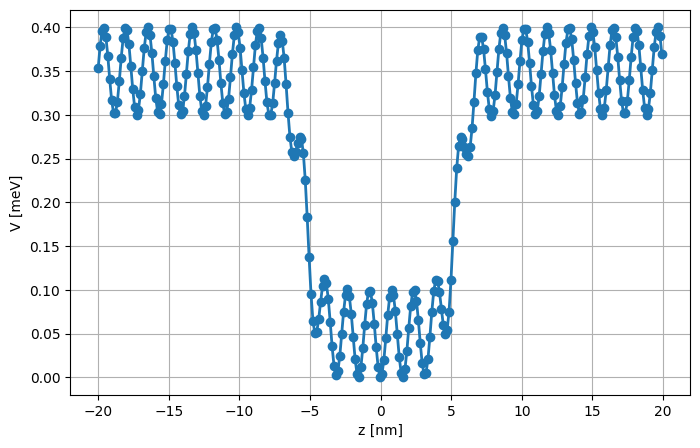

In [37]:
# visulalize Ge profile
plt.figure(figsize=(8, 5))
plt.plot(z_values, n(z_values), marker='o', linestyle='-', linewidth=2)

#Visualize confining potential 
# plt.plot(z_values, V_l(), marker='o', linestyle='-', linewidth=2)
plt.xlabel('z [nm]')
plt.ylabel('V [meV]')
plt.grid(True)
plt.show()


### 1-2 Visualize alloy disorder realizations 
According to Supplementary Materials in *g-factor theory of Si/SiGe quantum dots: spin-valley and giant renormalization effects* paper, sample random alloy disorders. 

Note that these values are averaged over xy plane with quantum dot (assumed harmonic potential in xy plane and use ground state $\chi_{00}(x,y)$ to compute average). 

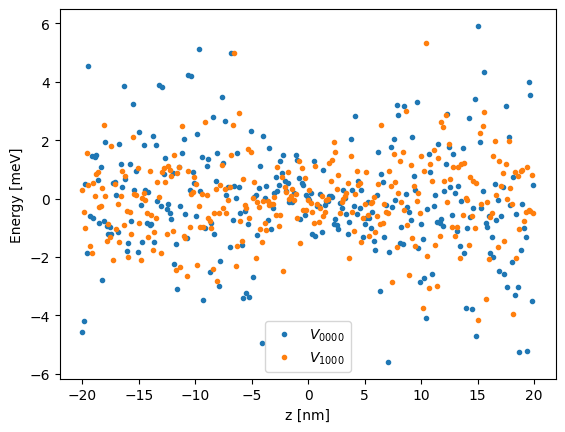

In [3]:
# visualize disorders 
V_0000, V_1000 = generate_disorders(z_values, n, l_t, E_G, a_t)
plt.plot(z_values, V_0000, '.', label=r'$V_{0000}$')
plt.plot(z_values, V_1000, '.', label=r'$V_{1000}$')

plt.xlabel('z [nm]')
plt.ylabel('Energy [meV]')
plt.legend()

### 1-3 Out of plane ($z$) electric field, $F_z$
Assumed the out of plane electric field $F_z^0$ is $5$ mV/nm. 

Assumptions for Electric field noise 
- Stationary, stochastic process

According to below papers,    
1. *Modeling of planar germanium hole qubits in electric and magnetic fields* 
2. *Quantum logic with spin qubits crossing the surface code threshold*   

$S(f) = A_z^2 / f$ where $A_z = 3.5 $ kV/m.  $\rightarrow \langle (F_z-F_z^0)^2 \rangle = \int_0^{\infty} S(f) df$     

This give standard deviation of $F_z$, $\sigma(F_z) = A_z \log (f_{max} / f_{min})$     


- $f_{max}$ is 1/time segment in the experiment, which is 1/(1 ps) 
- $f_{min}$ is 1/ measurement time, which is 1/(8 min). (In paper 2., Figure 3. T2 measurement is held with 8 min) 

this results in $\sigma(F_z)\sim 0.02$ mV/nm

Text(0.5, 0, 'Electric field noise [mV/nm]')

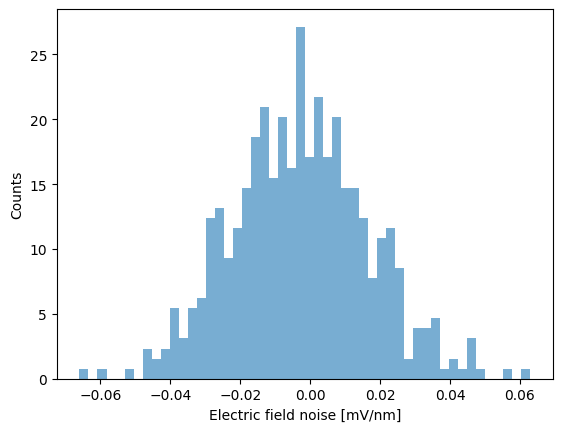

In [4]:
# Visualize electric field noise 

sample_size = 500
electric_noise = sample_noise(shape = (sample_size,))

plt.hist(electric_noise, bins=50, density=True, alpha=0.6)
plt.ylabel("Counts")
plt.xlabel("Electric field noise [mV/nm]")


### 1-4 Check with previous results. 

Generate valley splittings as a function of interface width to compare the figure in paper,  

*Practical strategies for enhancing the valley splitting in Si/SiGe quantum wells*.

- Valley splitting: $E_V = 2 |\Delta_{0000}^{00}|$
- where $\Delta_{0000}^{00} = \langle \chi_{00}(x,y)\psi(z)|V(\mathbf{r})e^{-2ik_0z}|\chi_{00}(x,y)\psi(z)\rangle=\langle\psi(z)|(V_{0000}(z)+V_l(z))e^{-2ik_0z}|\psi(z)\rangle$ 

Note that in this figure, no wiggle Ge concentration in the well.  

In [6]:
avg_size = 200 # number of disorder realizations 

result = np.zeros((avg_size, 20) )
ws = np.arange(1, 21) *(d_z) # interface widths 
electric_potential_ = electric_potential() # use 5 mV/nm

for i in range(20):
    for j in range(avg_size):
        width = ws[i]
        V_0000, V_1000 = generate_disorders(z_values, n, l_t, E_G, a_t, width, no_wiggle=True)
        gs = get_groundstate(z_values, well_potential=V_l(width, no_wiggle = True), disorder=V_0000, electric_noise=0, electric_potential=electric_potential_)
        Delta_0000 = expectation_value((V_l(width,no_wiggle=True)+ V_0000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        result[j, i]+= 2* Delta_0000[0]
        


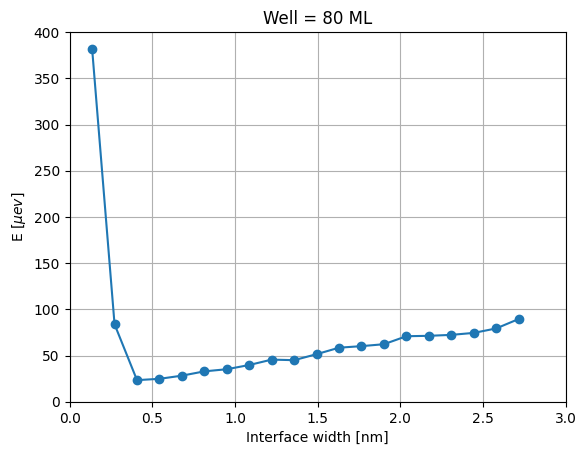

In [7]:

plt.plot(ws, result.mean(axis = 0)*10**3, '-o')

plt.ylabel('E '+r'$[\mu ev]$')
plt.xlabel('Interface width [nm]')
plt.grid() 
plt.axis([0, 3, 0, 400])

plt.title('Well = 80 ML')
plt.show() 

## 2. Calculate Rabi frequency $\Omega$

### 2-1 Hamiltonian 

$H = \frac{\hbar^2}{2m_l}k_z^2 + V_0 \cos(\frac{2\pi z}{\lambda}) + V_l (z) + \acute V_{0000}(z) + eF_z  $

- Quantum well : sigmoid well with wiggles, $V_0 \cos(\frac{2\pi z}{\lambda}) + V_l (z)$
   - potential :  $E_{GE} \times n(z) $
   - $V_0 = 30$ meV which corresponds to $n_{GE} = 0.05$, $E_{GE} = 0.6 $
- Out of plane electric field $F_z$ : $ F_z \sim N(F_z^0, \sigma (F_z))$    
   - $F_z^0 =$ 5 mV/nm, electric field without noise
   - $\sigma (F_z) \simeq$ 0.02 mV/nm, standard deviation

- Alloy disorder term : $\acute V_{0000} (z) $




In [ ]:
well_potential = V_l()
electric_potential_ = electric_potential()

realization_size = 2

Rabi_freqs = np.zeros((realization_size, sample_size)) 
calculated_values = np.zeros((realization_size, sample_size, 4, 2))


for i in range(realization_size):
    V_0000, V_1000 = generate_disorders(z_values, n, l_t, E_G, a_t)
    for j in range(sample_size):
        electric_noise_ = electric_noise[j]
        gs = get_groundstate(z_values, well_potential=well_potential, disorder=V_0000, electric_noise=electric_noise_, electric_potential=electric_potential_)
        
        
        Delta_0000 = expectation_value((well_potential+ V_0000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        Delta_1000 = expectation_value((well_potential+ V_1000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        beta =expectation_value(beta_0*np.exp((0+1j)*2*k_1*z_values), ground_state=gs)
        
        z_loc = expectation_value(z_values, ground_state=gs)
        z2_loc = expectation_value(z_values*z_values, ground_state=gs)
        z_center = z_loc[0]
        z_width = np.sqrt(z2_loc[0] - z_loc[0]**2)
        
        calculated_values[i, j, 0, 0], calculated_values[i, j, 0, 1] = Delta_0000 
        calculated_values[i, j, 1, 0], calculated_values[i, j, 1, 1] = Delta_1000 
        calculated_values[i, j, 2, 0], calculated_values[i, j, 2, 1] = beta 
        
        calculated_values[i, j, 3, 0], calculated_values[i, j, 3, 1] = z_center, z_width  
        
        
        Rabi_freq = calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple')
        
        Rabi_freqs[i,j]+=Rabi_freq
        

In [63]:
# # Rabi frequency, changes a lot if the sampled disorder terms vary
# plt.hist(np.abs(Rabi_freqs[0, :]), bins = 50, color ='tab:blue', alpha = 0.7,edgecolor='blue' )
# plt.hist(np.abs(Rabi_freqs[1, :]), bins = 50, color ='tab:orange', alpha = 0.7,edgecolor='orange' )

# plt.show()

### 2-2 Ground state 
For the ground state $|\psi(z)|^2$, refer to "slider.py" to generate figure.    
It will generate a slider that shows ground state profile in real space under noisy electric field. 

### 2-3 Expectation values. 
Check the distribution of $\Delta_{0000}$, $\Delta_{1000}$ and $\beta_{00}$

- $\Delta_{0000}= \langle\psi(z)|(V_{0000}(z)+V_l(z))e^{-2ik_0z}|\psi(z)\rangle$ 
- $\Delta_{1000} =\langle\psi(z)|(V_{1000}(z)+V_l(z))e^{-2ik_0z}|\psi(z)\rangle$ 
- $\beta_{00} = \langle\psi(z)|\beta_0 e^{2ik_1z}|\psi(z)\rangle$ 

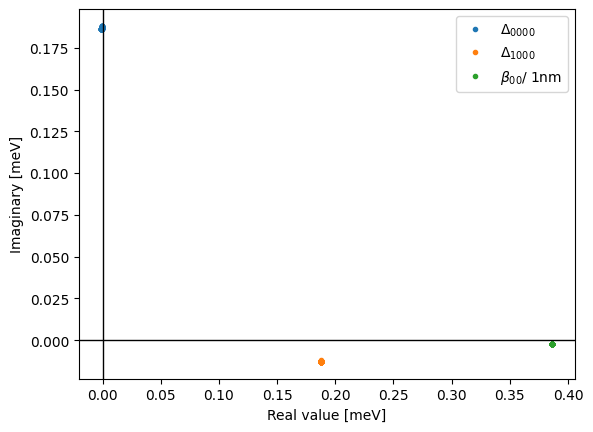

In [23]:
labels=[r'$\Delta_{0000}$',r'$\Delta_{1000}$',r'$\beta_{00}/\;1$'+'nm']
# colors = ['r', 'g', 'b']
def plot_complex(r, theta, label): 
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    plt.plot(x, y, '.', label = label)
    # plt.arrow(0, 0, x.mean()-0.01, y.mean()-0.01, head_width=0.01, head_length=0.01,  fc='black', ec=color)

for i in range(3):
    r = calculated_values[0, :, i, 0]
    theta = calculated_values[0, :, i, 1]
    plot_complex(r, theta, labels[i])

plt.axhline(0, color='black', linewidth=1)  # X-axis at y=0
plt.axvline(0, color='black', linewidth=1)  # Y-axis at x=0

plt.xlabel('Real value [meV]')
plt.ylabel('Imaginary [meV]')
plt.legend()
plt.show()

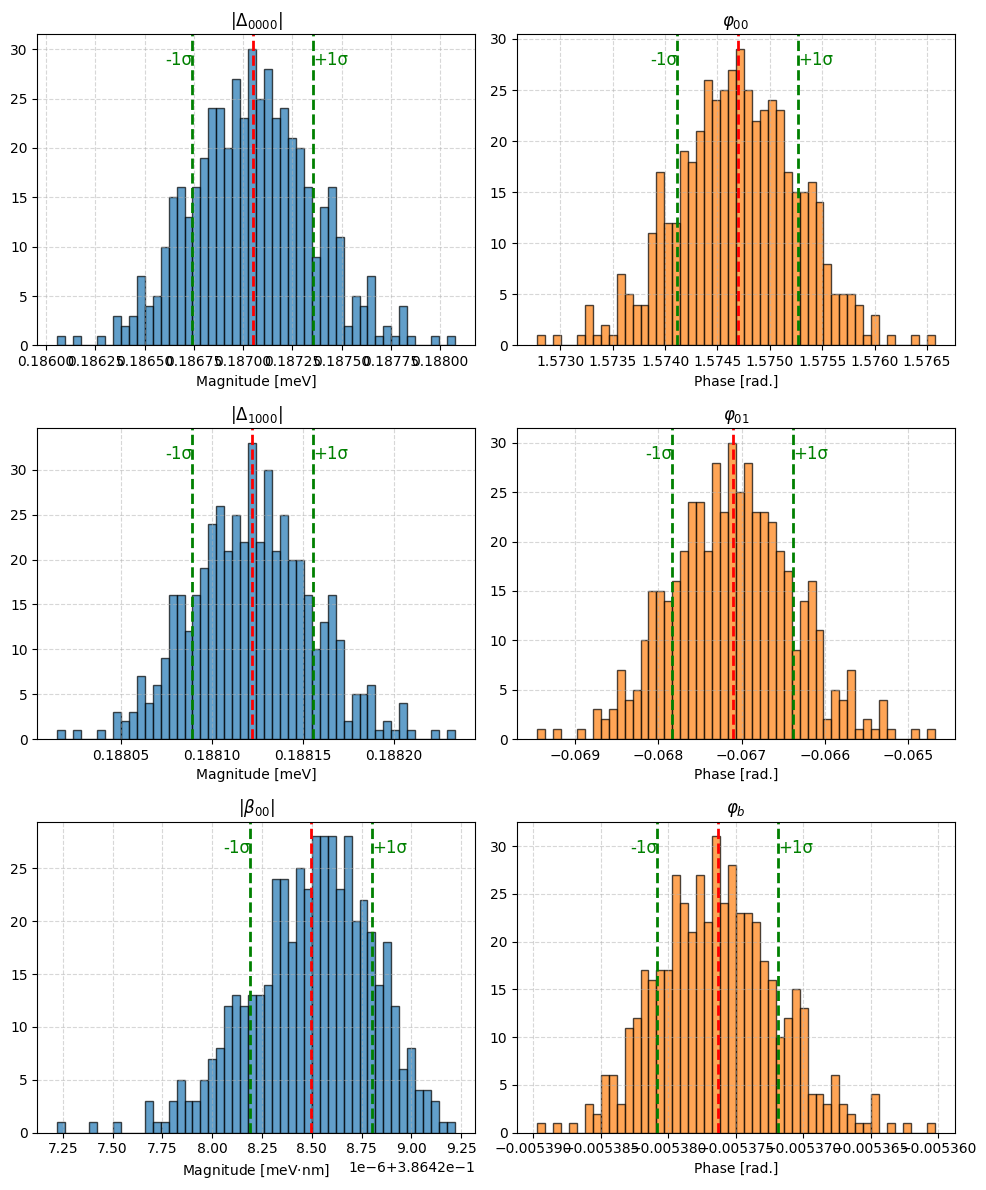

In [24]:
num_bins = 50  # Number of histogram bins

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12)) 


label_abs = [r'$|\Delta_{0000}|$',r'$|\Delta_{1000}|$',r'$|\beta_{00}|$']
label_angle = [r'$\varphi_{00}$',r'$\varphi_{01}$',r'$\varphi_{b}$']

for i in range(3):
    # Left column: Histogram of length
    axes[i, 0].hist(calculated_values[0, :, i, 0], bins=num_bins, color='tab:blue', alpha=0.7, edgecolor='black')
    axes[i, 0].set_title(label_abs[i])
    axes[i, 0].set_xlabel("Magnitude [meV]")
    if i==2: 
        axes[i, 0].set_xlabel("Magnitude [meV"+r'$\cdot$'+"nm]")
    # axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].grid(True, linestyle="--", alpha=0.5)
    
    
    # Plot mean and standard deviation lines
    ax = axes[i, 0]
    mean = np.mean(calculated_values[0, :, i, 0])
    std_dev = np.std(calculated_values[0, :, i, 0])

    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean (μ)")
    ax.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=2)
    ax.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=2)

    # Annotate standard deviation
    ax.text(mean - std_dev, ax.get_ylim()[1] * 0.9, "-1σ", color='green', fontsize=12, ha='right')
    ax.text(mean + std_dev, ax.get_ylim()[1] * 0.9, "+1σ", color='green', fontsize=12, ha='left')
    # ax.text(mean + std_dev, ax.get_ylim()[1] * 0.9, "+1σ"+f' = {std_dev:.5f}', color='green', fontsize=12, ha='left')


    # Right column: Histogram of phase
    axes[i, 1].hist(calculated_values[0, :, i, 1], bins=num_bins, color='tab:orange', alpha=0.7, edgecolor='black')
    axes[i, 1].set_title(label_angle[i])
    axes[i, 1].set_xlabel("Phase [rad.]")
    # axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].grid(True, linestyle="--", alpha=0.5)
        
    # Plot mean and standard deviation lines
    ax = axes[i, 1]
    mean = np.mean(calculated_values[0, :, i, 1])
    std_dev = np.std(calculated_values[0, :, i, 1])

    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean (μ)")
    ax.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=2)
    ax.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=2)

    # Annotate standard deviation
    ax.text(mean - std_dev, ax.get_ylim()[1] * 0.9, "-1σ", color='green', fontsize=12, ha='right')
    ax.text(mean + std_dev, ax.get_ylim()[1] * 0.9, "+1σ", color='green', fontsize=12, ha='left')
    # ax.text(mean + std_dev, ax.get_ylim()[1] * 0.9, "+1σ"+f' = {std_dev:.5f}', color='green', fontsize=12, ha='left')


# Adjust layout
plt.tight_layout()

plt.show()


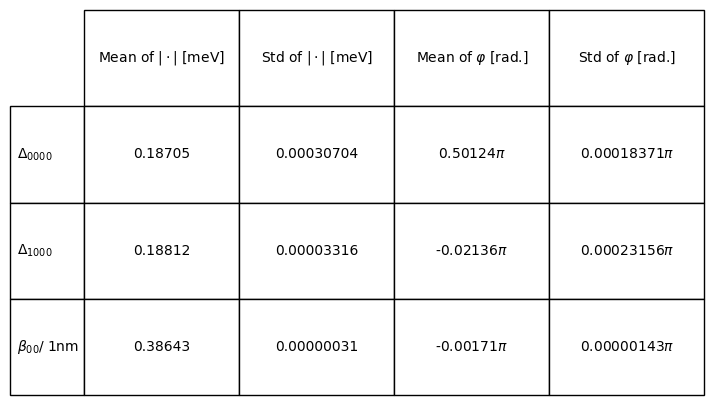

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.axis("off") 

table_abs_data = [[f"{np.mean(calculated_values[0, :, i, 0]):.5f}", f"{np.std(calculated_values[0, :, i, 0]):.8f}",f"{np.mean(calculated_values[0, :, i, 1])/np.pi:.5f}"+r'$\pi$', f"{np.std(calculated_values[0, :, i, 1])/np.pi:.8f}"+r'$\pi$']for i in range(3)]

column_labels = ["Mean of "+r'$| \cdot |$'+" [meV]", "Std of "+r'$| \cdot |$'+" [meV]", 'Mean of '+r'$\varphi$'+' [rad.]', 'Std of '+r'$\varphi$'+' [rad.]']

table_abs = plt.table(cellText=table_abs_data, colLabels=column_labels, rowLabels=labels,
                  cellLoc='center', loc='bottom', bbox=[0, 0, 1, 1])

plt.show()

### 2-4 Analyze distribution of Rabi frequency $\Omega$

$\Omega = \frac{eE \hbar\omega}{\hbar(\hbar\omega_t)^2}    |\beta^{00}|\bigl(\cos(\phi_{00}-\phi_{b}) -  \frac{|\Delta_{1000}^{00}|^2}{|\Delta_{0000}^{00}|^2}\sin(\phi_{b} - \phi_{01} )\sin(\phi_{00}-\phi_{01})\bigr)$     

- With specific device, disorders are fixed, Rabi frequency fluctuates due to electric field noise $\delta F_z$.    
- If the dot is at 'bad spot' Rabi frequency might be very small, which makes the normalized fluctuation blow up. 

In [ ]:
# It takes time!! 

timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMMSS

well_potential = V_l()
electric_potential_ = electric_potential()

realization_size = 400

Rabi_freqs = np.zeros((realization_size, 4)) # mean, 25, 75, std

calculated_values = np.zeros((realization_size, sample_size, 4, 2))

for i in range(realization_size):
    
    V_0000, V_1000 = generate_disorders(z_values, n, l_t, E_G, a_t)
    temp_Rabi_freqs = np.zeros((sample_size, ))
    
    for j in range(sample_size):
        electric_noise_ = electric_noise[j]
        gs = get_groundstate(z_values, well_potential=well_potential, disorder=V_0000, electric_noise=electric_noise_, electric_potential=electric_potential_)
        
        center_z = expectation_value(z_values, ground_state=gs)
        
        Delta_0000 = expectation_value((well_potential+ V_0000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        Delta_1000 = expectation_value((well_potential+ V_1000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        beta =expectation_value(beta_0*np.exp((0+1j)*2*k_1*z_values), ground_state=gs)
        
        calculated_values[i, j, 0, 0], calculated_values[i, j, 0, 1] = Delta_0000 
        calculated_values[i, j, 1, 0], calculated_values[i, j, 1, 1] = Delta_1000 
        calculated_values[i, j, 2, 0], calculated_values[i, j, 2, 1] = beta 
        
        calculated_values[i, j, 3, 0], calculated_values[i, j, 3, 1] = z_center, z_width  
        
        temp_Rabi_freqs[j]+=calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple_dipole')/10**9/B #GHz/T
        
        
        
    Rabi_freqs[i, 0] += np.mean(temp_Rabi_freqs)
    Rabi_freqs[i, 1] += np.percentile(temp_Rabi_freqs, 25)
    Rabi_freqs[i, 2] += np.percentile(temp_Rabi_freqs, 75)
    Rabi_freqs[i, 3] += np.std(temp_Rabi_freqs)
    

np.save(f"./Results/{timestamp}_Rabi_frequencies", Rabi_freqs)

### 2-5 Analyze Rabi frequency distribution as a function of electric field $F_z$ 

Use one sampled device (alloy disorders are fixed), check how Rabi frequency changes according to the elctric field. 
Here, I have used the same electric field noise as above, $\sigma (F_z) \simeq$ 0.02 mV/nm. 

In [ ]:
# Check the dependence of electric field 

timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMMSS

well_potential = V_l()

electric_field_sketch = np.linspace(1, 11, num = 100) # mV/nm 


Rabi_freqs = np.zeros((100, 4)) # mean, 25, 75, std
calculated_values = np.zeros((100, sample_size, 4, 2))

for i in range(len(electric_field_sketch)):
    electric_potential_ = electric_potential(F_z = electric_field_sketch[i])

    # V_0000, V_1000 = generate_disorders(z_values, n, l_t, E_G, a_t)
    temp_Rabi_freqs = np.zeros((sample_size, ))
    
    for j in range(sample_size):
        electric_noise_ = electric_noise[j]
        gs = get_groundstate(z_values, well_potential=well_potential, disorder=V_0000, electric_noise=electric_noise_, electric_potential=electric_potential_)
        
        
        Delta_0000 = expectation_value((well_potential+ V_0000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        Delta_1000 = expectation_value((well_potential+ V_1000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        beta =expectation_value(beta_0*np.exp((0+1j)*2*k_1*z_values), ground_state=gs)
        
        z_loc = expectation_value(z_values, ground_state=gs)
        z2_loc = expectation_value(z_values*z_values, ground_state=gs)
        z_center = z_loc[0]
        z_width = np.sqrt(z2_loc[0] - z_loc[0]**2)
        
        calculated_values[i, j, 0, 0], calculated_values[i, j, 0, 1] = Delta_0000 
        calculated_values[i, j, 1, 0], calculated_values[i, j, 1, 1] = Delta_1000 
        calculated_values[i, j, 2, 0], calculated_values[i, j, 2, 1] = beta 
        calculated_values[i, j, 3, 0], calculated_values[i, j, 3, 1] = z_center, z_width  
        
        temp_Rabi_freqs[j]+=calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple_dipole')/10**9/B #GHz/T
        
        
        
    Rabi_freqs[i, 0] += np.mean(temp_Rabi_freqs)
    Rabi_freqs[i, 1] += np.percentile(temp_Rabi_freqs, 25)
    Rabi_freqs[i, 2] += np.percentile(temp_Rabi_freqs, 75)
    Rabi_freqs[i, 3] += np.std(temp_Rabi_freqs)
    

np.save(f"./Results/F_z_{timestamp}_Rabi_frequencies", Rabi_freqs)
np.save(f"./Results/F_z_{timestamp}_calculated_exp_vs", calculated_values)

**2-5-1  Rabi frequency as a function of electric field $F_z$**

Text(0.5, 0, 'Electric field $F_z$ [mV/nm]')

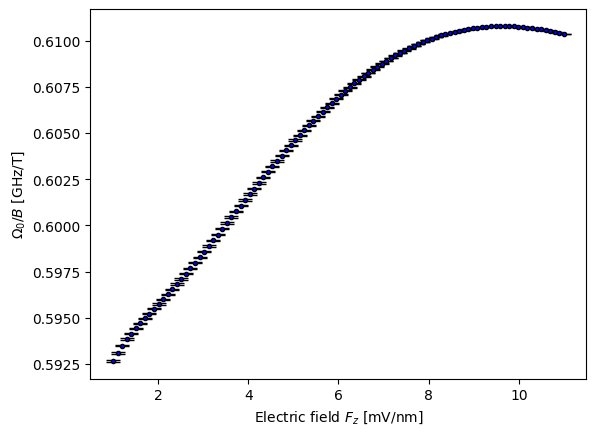

In [ ]:
plt.errorbar(electric_field_sketch, np.abs(Rabi_freqs[:, 0]), yerr=[Rabi_freqs[:, 0]-Rabi_freqs[:, 1] , Rabi_freqs[:, 2]-Rabi_freqs[:, 0]], fmt='.', capsize=5, capthick=1,ecolor='black', markerfacecolor='blue', markeredgecolor='black')
plt.ylabel(r'$\Omega_0/B$'+' [GHz/T]')
plt.xlabel('Electric field '+r'$F_z$'+' [mV/nm]')
plt.show()

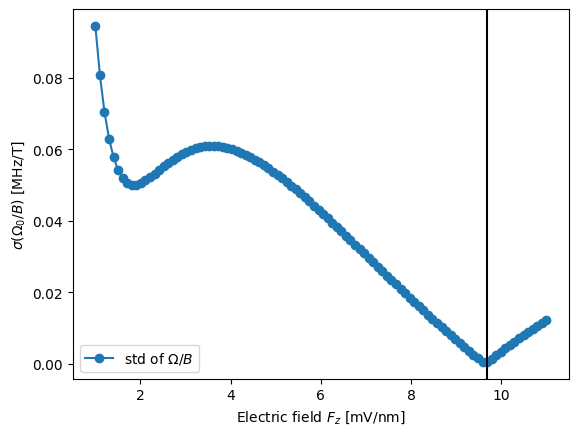

Min value at 9.686868686868687 mV/nm, the std is 0.0005022968859544611 MHz/T


In [74]:
plt.plot(electric_field_sketch, Rabi_freqs[:, 3]*10**3, '-o', label = 'std of '+r'$\Omega/B$')
min_value = electric_field_sketch[np.argmin(Rabi_freqs[:, 3])]
plt.axvline( x = min_value, color = 'k')
plt.xlabel('Electric field '+r'$F_z$'+' [mV/nm]')
plt.ylabel(r'$\sigma(\Omega_0/B)$'+' [MHz/T]')
plt.legend()

plt.show() 

print(f'Min value at {min_value} mV/nm, the std is {np.min(Rabi_freqs[:, 3])*10**3} MHz/T')

**2-5-2  center, width of ground state profile $|\psi(z)|^2$ as a function of electric field $F_z$**

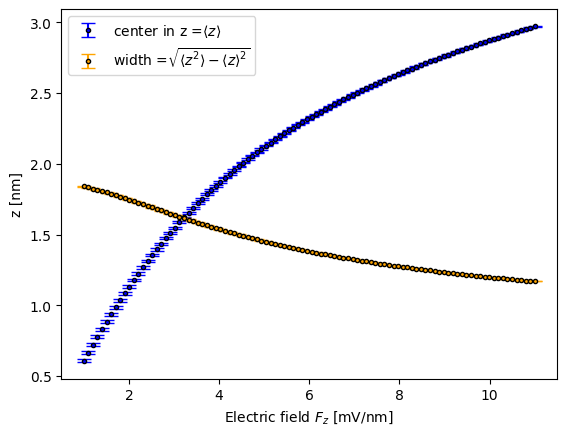

In [61]:
mean_z_loc = calculated_values[:, :, 3, 0].mean(axis = 1)
std_z_loc = calculated_values[:, :, 3, 0].std(axis = 1)

mean_z_width = calculated_values[:, :, 3, 1].mean(axis = 1)
std_z_width = calculated_values[:, :, 3, 1].std(axis = 1)

plt.errorbar(electric_field_sketch, mean_z_loc, yerr = [std_z_loc, std_z_loc],fmt='.', capsize=5, capthick=1,ecolor='blue', markerfacecolor='blue', markeredgecolor='black', label = 'center in z ='+r'$\langle z \rangle$')
plt.errorbar(electric_field_sketch, mean_z_width, yerr = [std_z_width, std_z_width],fmt='.', capsize=5, capthick=1,ecolor='orange', markerfacecolor='orange', markeredgecolor='black', label = 'width ='+r'$\sqrt{\langle z^2 \rangle-\langle z \rangle^2}$')

plt.xlabel('Electric field '+r'$F_z$'+' [mV/nm]')
plt.ylabel('z [nm]')
plt.legend()

Text(0.5, 1.0, 'If electric field gets stronger, the ground state fluctuates less')

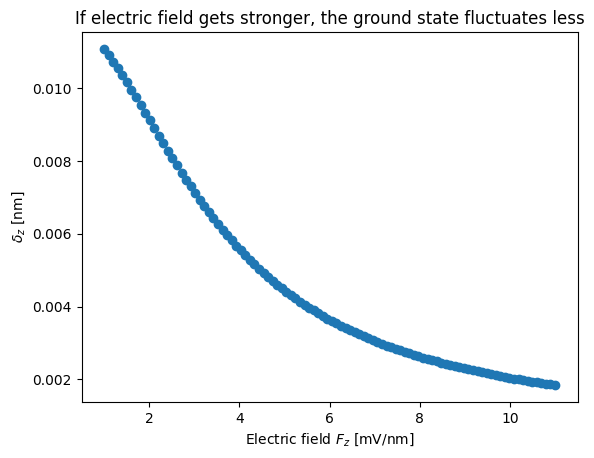

In [82]:
plt.plot(electric_field_sketch, std_z_loc, 'o')
plt.xlabel('Electric field '+r'$F_z$'+' [mV/nm]')
plt.ylabel(r'$\delta_z$'+' [nm]')
plt.title('If electric field gets stronger, the ground state fluctuates less')

**2-5-3 $|\Delta_{0000}|$, $|\Delta_{1000}|$  as a function of electric field $F_z$**

If electric field increases, the ground state shrinks, the fluctuation of disorder increases -> valley splitting increases. 

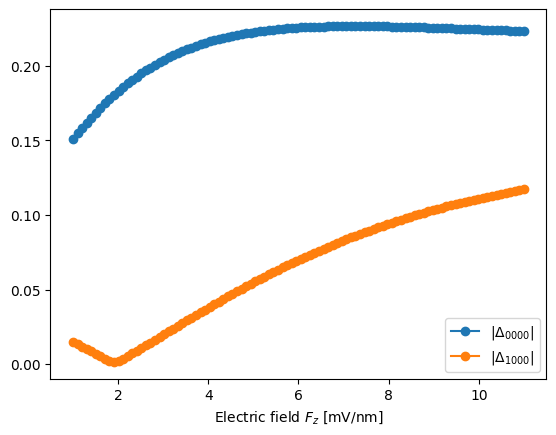

In [51]:
plt.plot(electric_field_sketch, calculated_values[:, :, 0, 0].mean(axis = 1),'-o', label = r'$|\Delta_{0000}|$')
plt.plot(electric_field_sketch, calculated_values[:, :, 1, 0].mean(axis = 1),'-o', label = r'$|\Delta_{1000}|$')

plt.xlabel('Electric field '+r'$F_z$'+' [mV/nm]')
plt.legend()

**Meeting notes**   
Tuesday meeting
- calculate movement in z direction and size changes 
-  Quality factor $ \Omega T_2$ 


Friday meeting 
-  electric field ratio between x, z 
- -> check when the noise in certain direction donimates 

- change the wiggle size
- check if the distribution remains same or not 

- Using different disorder, check when the fluctuation of Rabi frequency become the smallest. 


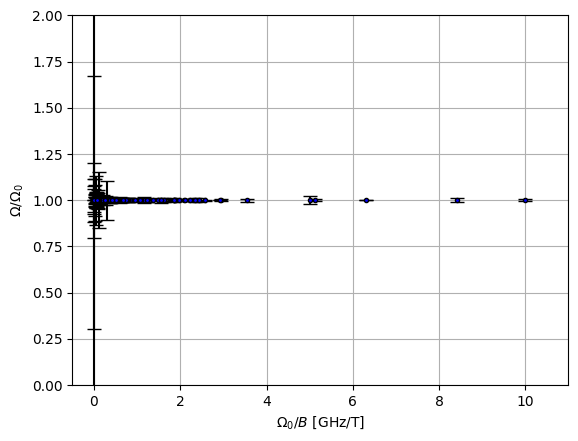

In [41]:
x = np.arange(realization_size)

lower_errors = (Rabi_freqs[:, 0]-Rabi_freqs[:, 1])/Rabi_freqs[:, 0]

upper_errors = (Rabi_freqs[:, 2]-Rabi_freqs[:, 0])/Rabi_freqs[:, 0]

plt.errorbar(np.abs(Rabi_freqs[:, 0]), Rabi_freqs[:, 0]/Rabi_freqs[:, 0], yerr=[lower_errors, upper_errors], fmt='.', capsize=5, capthick=1,ecolor='black', markerfacecolor='blue', markeredgecolor='black')

plt.xlabel(r'$\Omega_0/B$'+' [GHz/T]')
plt.ylabel(r'$\Omega/\Omega_0$')
plt.grid(True)
plt.axis([-0.5, 11, 0, 2])
# plt.yscale('log')
plt.show()


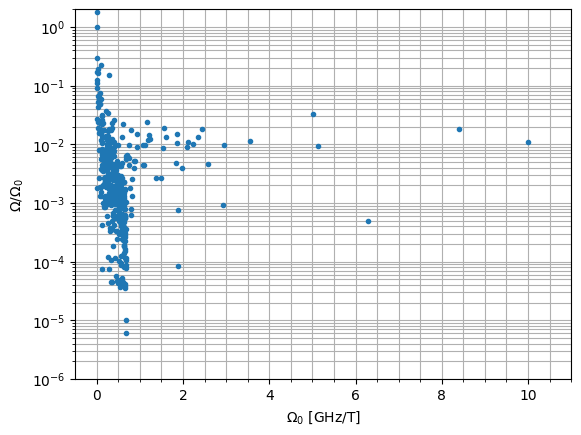

In [34]:
plt.plot(np.abs(Rabi_freqs[:, 0]), Rabi_freqs[:, 3]/np.abs(Rabi_freqs[:, 0]), '.')
plt.minorticks_on()
plt.grid(which='both')
plt.xlabel(r'$\Omega_0$'+' [GHz/T]')
plt.ylabel(r'$\Omega/\Omega_0$')

plt.axis([-0.5, 11, 10**(-6), 2])
plt.yscale('log')
plt.show()

In [38]:
# print outliers 
th = 0.04
for i in range(realization_size):
    if Rabi_freqs[i, 3]/np.abs(Rabi_freqs[i, 0])>th:
        print(f'{i}th Rabi freq = {Rabi_freqs[i, 0]}, '+f'std={Rabi_freqs[i, 3]}')

9th Rabi freq = 0.08395134763932402, std=0.006307035172758775
62th Rabi freq = -0.040758421019529756, std=0.0026910329824309377
70th Rabi freq = 0.03002206753945362, std=0.0015513063605847408
80th Rabi freq = 0.006773435021372719, std=0.0007545148864842442
87th Rabi freq = 0.2913613641064892, std=0.04470297241324088
98th Rabi freq = -0.01565476480198534, std=0.001923546626615061
105th Rabi freq = -0.03160072074185677, std=0.0013562209213657404
129th Rabi freq = -0.008941319352940536, std=0.0026374260074403764
137th Rabi freq = 0.11002487202812725, std=0.02438808913822137
180th Rabi freq = -0.0638828055662531, std=0.0040851914913426655
191th Rabi freq = -0.04274087647643693, std=0.0025068008842416044
198th Rabi freq = -0.06594452542576311, std=0.0032287316080753473
216th Rabi freq = -0.0010472467836994594, std=0.0010418742199304715
246th Rabi freq = 0.02953687135451984, std=0.004855521822262439
263th Rabi freq = -14.594902712048762, std=0.7075384449668748
265th Rabi freq = 0.05013599455

In [39]:
# for l in range(realization_size):
#     plt.hist(Rabi_freqs[l]/ np.mean(Rabi_freqs[l]), bins = 50, density=True, alpha=0.6)
#     plt.ylabel("counts")
#     plt.xlabel("Rabi frequency [arb.]")
#     # plt.axis([-0.2, 0.4, 0, 1500])
#     # plt.yscale('log')
    
#     print(f'Mean = {np.mean(Rabi_freqs[l]):.3f}, std = {np.std(result[l]):.5f}')
    # plt.title(f'Mean = {np.mean(result[l]):.3f}, std = {np.std(result[l]):.5f}')

In [12]:
''' Takes time 
# Calculate valley splitting with various interface width
sampling_size = 50 
result = np.zeros((sampling_size, 20) )
ws = np.arange(1, 21) *(d_z)

for i in range(20):
    for j in range(sampling_size):
        w = ws[i]
        length = len(z_values)
        
        V_0000, V_1000 = generate_disorders(z_values, n, l_t, E_G, a_t, w)

        t = - hbar**2 / 2 / m_l / d_z**2 * 10**18
        potential =  V_l(w) + V_0000
        diag_terms =-2*t * np.ones((length,)) + potential + electric_potential()
        diag_terms = np.repeat(diag_terms, 2) # extend dimension to include valley terms     
        
        valley_terms= np.zeros(len(diag_terms)-1, dtype= np.complex128)
        valley_terms[::2] +=potential *np.exp((0-1j)*2*k_0*z_values)

        H = np.diag(diag_terms).astype(np.complex128)
        H += np.diag(valley_terms, -1)
        H += np.diag(valley_terms.conj(), -1).T        
        H += np.diag(t* np.ones((2*length-2,)), -2)
        H += np.diag(t* np.ones((2*length-2,)), -2).T

        # find ground state 
        D, V = np.linalg.eigh(H)
        # ground_state = V[:, 0]
        # Delta =  np.dot(ground_state.conj(), potential *np.exp((0-1j)*2*k_0*z_values)*ground_state)
        result[j, i]+= D[1]-D[0]
        '''


' Takes time \n# Calculate valley splitting with various interface width\nsampling_size = 50 \nresult = np.zeros((sampling_size, 20) )\nws = np.arange(1, 21) *(d_z)\n\nfor i in range(20):\n    for j in range(sampling_size):\n        w = ws[i]\n        length = len(z_values)\n        \n        V_0000, V_1000 = generate_disorders(z_values, n, l_t, E_G, a_t, w)\n\n        t = - hbar**2 / 2 / m_l / d_z**2 * 10**18\n        potential =  V_l(w) + V_0000\n        diag_terms =-2*t * np.ones((length,)) + potential + electric_potential()\n        diag_terms = np.repeat(diag_terms, 2) # extend dimension to include valley terms     \n        \n        valley_terms= np.zeros(len(diag_terms)-1, dtype= np.complex128)\n        valley_terms[::2] +=potential *np.exp((0-1j)*2*k_0*z_values)\n\n        H = np.diag(diag_terms).astype(np.complex128)\n        H += np.diag(valley_terms, -1)\n        H += np.diag(valley_terms.conj(), -1).T        \n        H += np.diag(t* np.ones((2*length-2,)), -2)\n        H 